# ADVANCED TEXT MINING
- 본 자료는 텍스트 마이닝을 활용한 연구 및 강의를 위한 목적으로 제작되었습니다.
- 본 자료를 강의 목적으로 활용하고자 하시는 경우 꼭 아래 메일주소로 연락주세요.
- 본 자료에 대한 허가되지 않은 배포를 금지합니다.
- 강의, 저작권, 출판, 특허, 공동저자에 관련해서는 문의 바랍니다.
- **Contact : ADMIN(admin@teanaps.com)**

---

In [1]:
# 텍스트 분석을 위한 TEANAPS 패키지를 설치합니다.
# TEANAPS는 Google Colaboratory/Linux 환경에 최적화되어 있습니다.
# Windows 환경에서 일부 기능에 제한이 있을 수 있습니다.

In [2]:
# TEANAPS (https://github.com/fingeredman/teanaps)
#!git clone https://github.com/fingeredman/teanaps.git

In [3]:
#!ls

In [4]:
#!python "teanaps/teanaps_setup.py"

## WEEK 11-1. 개봉전 영화리뷰로 총 관객수 예측하기
- Python으로 개봉전 영화리뷰를 활용해 총 관객수를 예측하는 방법에 대해 다룹니다.

---

### 1. 학습데이터 준비하기

---

#### 1.1. TEANAPS 라이브러리 불러오기

---

In [55]:
from teanaps.nlp import MorphologicalAnalyzer
from teanaps.nlp import Processing
from teanaps.handler import FileHandler
from teanaps.text_analysis import TfidfCalculator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

ma = MorphologicalAnalyzer()
ma.set_tagger("mecab")
tfidf = TfidfCalculator()
processing = Processing()
fh = FileHandler()

#### 1.2. 데이터 파일 불러오기: 영화정보

---

In [8]:
movie_dict = {}

f = open("data/movie_list.txt", encoding="utf-8")
for line in f:
    line = line.strip()
    col = line.split("\t")
    movie_name = col[0]
    opening_date = col[1]
    viewer = int(col[2].strip().replace(",", ""))
    movie_code = col[3]
    movie_dict[movie_name] = {"viewer": viewer, "opening_date": opening_date}
f.close()

In [9]:
movie_dict

{'택시운전사': {'viewer': 12186327, 'opening_date': '20170802'},
 '공조': {'viewer': 7817618, 'opening_date': '20170118'},
 '스파이더맨: 홈 커밍': {'viewer': 7258678, 'opening_date': '20170705'},
 '범죄도시': {'viewer': 6879841, 'opening_date': '20171003'},
 '군함도': {'viewer': 6592151, 'opening_date': '20170726'},
 '청년경찰': {'viewer': 5653270, 'opening_date': '20170809'},
 '더 킹': {'viewer': 5317693, 'opening_date': '20170118'},
 '미녀와 야수': {'viewer': 5138328, 'opening_date': '20170316'},
 '킹스맨: 골든 서클': {'viewer': 4945484, 'opening_date': '20170927'},
 '토르: 라그나로크': {'viewer': 4853778, 'opening_date': '20171025'},
 '꾼': {'viewer': 4018035, 'opening_date': '20171122'},
 '남한산성': {'viewer': 3849087, 'opening_date': '20171003'},
 '미이라': {'viewer': 3689325, 'opening_date': '20170606'},
 '분노의 질주: 더 익스트림': {'viewer': 3653238, 'opening_date': '20170412'},
 '너의 이름은.': {'viewer': 3637608, 'opening_date': '20170104'},
 '슈퍼배드 3': {'viewer': 3324874, 'opening_date': '20170726'},
 '아이 캔 스피크': {'viewer': 3279296, 'opening_d

#### 1.3. 데이터 파일 불러오기: 영화리뷰

---

In [37]:
import datetime

data = []
progress = 0

f = open("data/movie_comment_17-19_pre.txt", encoding="utf-8")
for line in f:
    progress += 1
    print(progress, end="\r")
    
    line = line.replace("\n", "")
    #print(line)
    col = line.split("\t")
    movie_name = col[0]
    date_time = col[1]
    #_date_time = datetime.datetime.strptime(date_time, "%Y.%m.%d %H:%M")
    opening_date = movie_dict[movie_name]["opening_date"]
    #opening_date = datetime.datetime.strptime(opening_date, "%Y%m%d")
    comment = col[2]
    # 개봉일 이전 리뷰만 필터링
    #print(_date_time, opening_date)
    #if _date_time <= opening_date + datetime.timedelta(days=3):
    data.append([movie_name, date_time, comment])
f.close()

In [38]:
print(len(data))

684270


In [39]:
data[:3]

[['택시운전사',
  '2017.08.02 09:29',
  '송강호 유해진 류준열이 한번씩 눈물 쏟게 만듦.. 그날의 광주에 택시운전사와 함께 다녀온 듯 먹먹하다'],
 ['택시운전사', '2017.08.02 09:28', '최근에 본 영화중 가장 돈이 안 아까운 영화!'],
 ['택시운전사',
  '2017.08.02 09:24',
  '신파일까봐 걱정했는데 신파는 커녕 눈물이 날만하면 가차없이 유쾌함을 던져주던 담백한 영화,,덕분에 억지 눈물이 아닌 진짜 눈물만 나왔다']]

#### 1.4. 텍스트 데이터 임베딩: TF-IDF Matrix

---

In [46]:
movie_comment_dict = {}
POS_LIST = ["NNP", "NNG"]

index = 0
for movie_name, date_time, comment in data:
    index += 1
    print(index, end="\r")
    
    # 명사형 문장 만들기
    pos_result = ma.parse(comment)
    pos_sentence = processing.get_plain_text(pos_result, pos_list=POS_LIST, tag=False)
    
    # 영화별 명사형 문장 Dictionary에 저장하기
    if movie_name in movie_comment_dict.keys():
        movie_comment_dict[movie_name] += " " + pos_sentence
    else:
        movie_comment_dict[movie_name] = pos_sentence

In [47]:
movie_comment_list = []
movie_viewer_list = []

for movie_name, pos_sentence_list in movie_comment_dict.items():
    movie_comment_list.append(pos_sentence_list)
    movie_viewer_list.append(movie_dict[movie_name]["viewer"])

In [49]:
len(movie_comment_list)

283

In [48]:
movie_comment_list[0]

'송강호 유해진 류준열 눈물 그날 광주 택시 운전사 최근 영화 돈 영화 신파 걱정 신파 눈물 날 영화 덕분 억지 눈물 눈물 영화 권력 굴복 시민 위르겐 힌츠페터 감사 배우 연기 역사 상황 가슴 픽션 사실 기반 영화 눈물 옆 자리 할머니 할아버지 눈물 빨갱이 단어 전두환 최대한 목격 광주 울림 영화 시사회 소재 마음 영화 영화 강추 이번 시사회 당첨 신랑 영화 끝 마음 후회 한국 영화 기대 합 당 아침 여운 그날 시선 감동 웃음 드라마 오늘 하루 생각 그때 상황 말 연기 몰입 영화 영화 유쾌 가슴 간만 영화 송강호 유해진 류준열 연기 최고 위르겐 힌츠페터 인물 재미 슬픔 감동 영화 가족 부모 강추 땅 감사 송강호 이입 몰입 엄마 아빠 회사 시사회 국민 배우 송강호 찬사 류준열 그동안 영화 독일 기자 서울 택시 운전사 시선 영화 언론통제 날 참상 인간 분노 역사 그때 죄 마음 영화 상처 역사 영화 택시 운전사 전두환 역사 민족 미래 영화 택시 운전사 오전 개봉 다큐 고증 오락 픽션 구성 최근 광주 관련 영상 압권 생각 추천 영화 영화 가슴 김 사복 애국 열사 전두환 영화 시사회 때 돈 돈 값 영화 민주 운동 나라 교과서 줄 민주 희생 전 금남 거리 송강호 연기 최고 감동 묘사 이유 베 평점 테러 시작 광주 사람 마음 거부 광주 그날 감동 경험 감사 영화 보고 광주 민주 운동 홍어 빨갱이 폭도 무식 사람 오랜만 한국 영화 배우 연기 감동 송강호 감정 연기 가슴 최고 송강호 최고 이유 유해진 대박 류준열 반전 대박 군함 실망 맘 정화 눈물 영화 울림 배우 연기 여운  송강호 유해진 류준열 외국 배우 연기 송강호 시선 외부 입장 공감대 형성 감정 택시 운전사 평점 테러 베 충 사회악 인생 영화 진심 송강호 진심 갑 정권 일 본인 이익 영화 소신 참여 변호인 때 최고 배우 시민 군인 고인 명복 빕 택시 운전사 시사회 슬픔 분노 눈물 지금 세상 감사 명연기 명배우 감탄사 대신 오랫만 시사회 추천 영화 주연 배우 연기 류준열 앞 기대 배우 모자람 완벽 조합 최고 캐스팅 굿 

In [185]:
# TF-IDF 계산
tfidf.calculation_tfidf(movie_comment_list, 
                        tf_vectorizer_path="data/tf_vectorizer", 
                        tfidf_vectorizer_path="data/tfidf_vectorizer")
tfidf_matrix = tfidf.get_tfidf_matrix().values[:]

# 정답 label 불러오기
label_list = movie_viewer_list

# 학습데이터/평가데이터 분리
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, label_list, test_size=0.20, random_state=True)

### 2. 학습하기

---

In [186]:
mlr_model = LinearRegression()
mlr_model.fit(x_train, y_train) 

# 학습모델 저장
fh.save_data("data/mlr_model", mlr_model)

In [187]:
y_predict = mlr_model.predict(x_train)

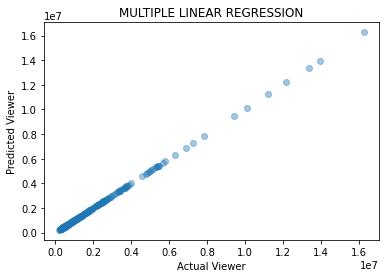

In [188]:
plt.scatter(y_train, y_predict, alpha=0.4)
plt.xlabel("Actual Viewer")
plt.ylabel("Predicted Viewer")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [189]:
y_predict = mlr_model.predict(x_test)

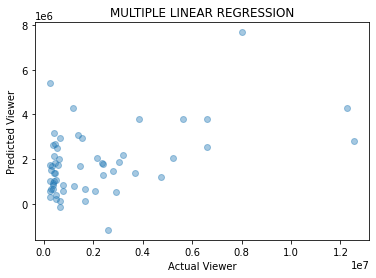

In [190]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual Viewer")
plt.ylabel("Predicted Viewer")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

### 3. R-Squared 평가하기

---

In [191]:
r_squared = mlr.score(x_train, y_train)
print("전체 영화 관객수 데이터의", r_squared, "를 설명 가능한 모델로 평가됨")

전체 영화 관객수 데이터의 0.9320994099527853 를 설명 가능한 모델로 평가됨


### 4. 학습모델 활용하기

---

#### 4.1. 새로운 영화리뷰 수집하기

---

In [192]:
from bs4 import BeautifulSoup 
import requests
import datetime

In [203]:
#MOVIE_CODE = "76016"
#MOVIE_CODE = "73318"
MOVIE_CODE = "130786"
#TITLE = "써니"
#TITLE = "시라노 연애조작단"
TITLE = "조선마술사"

SAVE_FILE_PATH = "data/movie_comment.txt"
f = open(SAVE_FILE_PATH, "w", encoding="utf-8")


# 전체 댓글개수 가져오기
URL = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=" + MOVIE_CODE + "&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=1"
response = requests.get(URL)
soup = BeautifulSoup(response.text, "html.parser")
comment_total = int(soup.find("strong", {'class': "total",}).find("em",).text.replace(",", ""))
page_limit = comment_total/10
if page_limit % 1 > 0:
    page_limit = int(page_limit) + 1
else:
    page_limit = int(page_limit)
# 댓글 가져오기
for page in range(1, page_limit+1):
    print(page, "/", page_limit, end="\r")
    URL = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=" + MOVIE_CODE + "&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page="
    URL = URL + str(page)
    response = requests.get(URL)
    soup = BeautifulSoup(response.text, "html.parser")
    comment_list = soup.findAll("div", {'class': "score_reple",})
    for comment in comment_list:
        try:
            span_tag_list = comment.find("p").findAll("span")
            date_time = comment.findAll("em")[1].text
            if span_tag_list[0].text == "관람객":
                f.write(TITLE + "\t" + date_time + "\t" + span_tag_list[1].text.strip() + "\n")
            else:
                f.write(TITLE + "\t" + date_time + "\t" + span_tag_list[0].text.strip() + "\n")
        except:
            continue
    f.flush()
    
f.close()

#### 4.2. 개봉일 이후 3개월 리뷰만 필터링하기

---

In [204]:
#opening_date = "20110504" # 써니
#opening_date = "20100916" # 시라노 연애조작단
opening_date = "20151230" # 조선마술사

sample_data = []
progress = 0

f = open("data/movie_comment.txt", encoding="utf-8")
for line in f:
    progress += 1
    print(progress, end="\r")
    
    line = line.replace("\n", "")
    #print(line)
    col = line.split("\t")
    try:
        movie_name = col[0]
        date_time = col[1]
        _date_time = datetime.datetime.strptime(date_time, "%Y.%m.%d %H:%M")
        opening_datetime = datetime.datetime.strptime(opening_date, "%Y%m%d")
        comment = col[2]
        # 개봉일 이전 리뷰만 필터링
        #print(_date_time, opening_date)
        if _date_time <= opening_datetime + datetime.timedelta(days=3):
            sample_data.append([movie_name, date_time, comment])
    except:
        continue
f.close()

In [205]:
len(sample_data)

1994

In [206]:
sample_data[:3]

[['조선마술사',
  '2015.12.30 23:01',
  '끼워맞춘듯한 캐릭터설정, 장르는 드라마인데 드라마도 아니고 코믹도 아니고 액션도 아니고 멜로도 아니고 어정쩡한 기분, 큰 스크린에서 볼때 엄청 어색했던 CG, 인과성이 부족한 장면전환, 총체적 난국인데 글을 잘 못써...'],
 ['조선마술사',
  '2015.12.30 20:37',
  '주인공은 마술하랬더니 연애하고 있고, 제작사는 사극기대하게 해놓고는 웹소설 만들어놓고, 배급사는 마케팅은 안하고 알바들만 풀어놓는구나...'],
 ['조선마술사', '2015.12.30 20:34', '유승호의 눈이 파란건 도데체 무엇을 의도한걸까 ㅋㅋㅋ']]

In [207]:
pos_sentence = ""

for movie_name, date_time, comment in sample_data:
    pos_result = ma.parse(comment)
    pos_sentence += " " + processing.get_plain_text(pos_result, pos_list=POS_LIST, tag=False)

In [208]:
pos_sentence[:200]

' 캐릭터 설정 장르 드라마 드라마 코믹 액션 멜 기분 스크린 때 인과 부족 장면 전환 총체 난국 글 주인공 마술 연애 제작사 사극 기대 웹 소설 배급사 마케팅 유승호 눈 의도 도대 장르 글 도중 토 중간 좌석 욕 영화 대나 사실 영화 볼 영화 곽도원 대신 주인공 영화 끝 내생 영화 처음 조선 알 돈 결말 전체 내용 돈 시간 글 최근 영화 최악 내용 편집 재'

In [209]:
input_vector = tfidf.get_tfidf_vector(pos_sentence, tfidf_vectorizer_path="data/tfidf_vectorizer")
# 학습모델 불러오기
model = fh.load_data("data/mlr_model")
# 분류수행
predict = int(model.predict([input_vector]).tolist()[0])
predict

567830

    - 영화관객수 확인 링크
> http://www.kobis.or.kr/kobis/business/main/main.do